# CS 342 Final Project - Letter Recognition CNN

Mrityunjay Mishra, Mihir Suvarna, Daniel Sialm

## Project Description

This project aims to create a convolutional neural network (CNN) for the task of letter recognition. The task of letter recognition, or more generally speaking, text recognition (also known as optical character recognition, or OCR) has gained much importance in recent years due to emerging applications. For example, OCR software can be used to convert handwritten text into digital text and robots use cameras to read signs in their environment. Due to the increasing importance of the task of text recognition, we aim to create a robust CNN that is able to correctly classify handwritten and digital letters.

In [1]:
# Run these two blocks to load important libraries and set things up
import torch
from torch import nn
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

## Load Dataset

### EMNIST Data Set

In [2]:
from torchvision import datasets, transforms

save_dir = 'letterEMNIST'

transform = transforms.ToTensor() # Convert the image into a torch tensor.

train_set = datasets.EMNIST(save_dir, split="letters", download=True, train=True, transform=transform)
test_set = datasets.EMNIST(save_dir, split="letters", download=True, train=False, transform=transform)

print(train_set)
print(test_set)

Dataset EMNIST
    Number of datapoints: 124800
    Root location: letterEMNIST
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset EMNIST
    Number of datapoints: 20800
    Root location: letterEMNIST
    Split: Test
    StandardTransform
Transform: ToTensor()


In [3]:
from torch.utils.data.sampler import SubsetRandomSampler
ntotal = 60000
ntrain = int(0.9*ntotal)
nval = ntotal - ntrain

val_ix = np.random.choice(range(ntotal), size=nval, replace=False)
train_ix = list(set(range(ntotal)) - set(val_ix))

train_sampler = SubsetRandomSampler(train_ix)
val_sampler = SubsetRandomSampler(val_ix)

In [4]:
# initialize the data sets
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, sampler=val_sampler)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size)

['N/A', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
Label: w


AttributeError: 

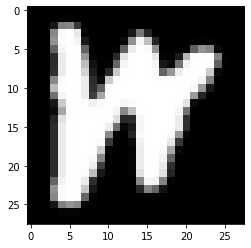

In [32]:
# print classes
print(train_set.classes)
classes = train_set.classes
# print label
index = 0
plt.imshow(train_set.data[index].T, cmap='Greys_r')
print("Label: %s" % train_set.classes[train_set.targets[index]])

### Collected Data

In [6]:
letter_to_label = dict()
classes_collected = ['N/A', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
for i in range(len(classes_collected)):
    letter_to_label[classes_collected[i]] = i
print(letter_to_label)

{'N/A': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26}


In [76]:
# making a dataset of our data
import os
import shutil
import glob

from PIL import Image
import torchvision.transforms as transforms

transform = transforms.ToTensor()

src_dir = 'dataset'
imgs = []
labels = []
for f in glob.glob(os.path.join(src_dir, '*.png')):
    ftitle, fext = os.path.splitext(os.path.basename(f))
    letter = ftitle.split("_")[1].lower()
    labels.append(letter_to_label[letter])
    im = Image.open(f).convert('L')
    imgs.append(transform(im).detach().numpy()*255)
data = torch.tensor(imgs)
labels = np.array(labels)

print(data.shape)
print(labels.shape)

torch.Size([234, 1, 28, 28])
(234,)


In [77]:
# shuffling the data
ntotal = data.shape[0]
ntrain = int(0.7*ntotal)
nval = (ntotal - ntrain) // 2

indices = torch.randperm(ntotal)
data = data[indices]
labels = torch.tensor(labels[indices])



batch_size = 64
train_set_collected = torch.utils.data.TensorDataset(data[:ntrain], labels[:ntrain])
val_set_collected = torch.utils.data.TensorDataset(data[ntrain:ntrain+nval], labels[ntrain:ntrain+nval])
test_set_collected = torch.utils.data.TensorDataset(data[ntrain+nval:], labels[ntrain+nval:])
data_set_collected = torch.utils.data.TensorDataset(data, labels)

train_loader_collected = torch.utils.data.DataLoader(train_set_collected, batch_size=batch_size)
val_loader_collected = torch.utils.data.DataLoader(val_set_collected, batch_size=batch_size)
test_loader_collected = torch.utils.data.DataLoader(test_set_collected, batch_size=batch_size)
data_loader_collected = torch.utils.data.DataLoader(data_set_collected, batch_size=batch_size)

['N/A', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
Label: t


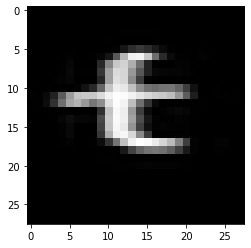

In [78]:
# print classes
print(classes_collected)
# print label
index = 0
plt.imshow(data[index].reshape((28, 28)), cmap='Greys_r')
print("Label: %s" % classes_collected[labels[index].item()])

## Testing CNNs

In [71]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

def train_network(model, train_loader, val_loader, criterion, optimizer, nepoch=100):
    try:
        for epoch in tqdm(range(nepoch)):
            print('EPOCH %d'%epoch)
            total_loss = 0
            count = 0
            for inputs, labels in train_loader:
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
                count += 1
            print('{:>12s} {:>7.5f}'.format('Train loss:', total_loss/count))
            with torch.no_grad():
                total_loss = 0
                count = 0
                for inputs, labels in val_loader:
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    total_loss += loss.item()
                    count += 1
                print('{:>12s} {:>7.5f}'.format('Val loss:', total_loss/count))
            print()
    except KeyboardInterrupt:
        print('Exiting from training early')
    return

def test_network(model, test_loader):
    correct = 0
    total = 0
    true, pred = [], []
    with torch.no_grad():
        for inputs, labels  in test_loader:
            outputs = model(inputs)
            predicted = torch.argmax(outputs, dim=1) # get predicted class label for each test example.
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            true.append(labels)
            pred.append(predicted)
    acc = (100 * correct / total)
    true = np.concatenate(true)
    pred = np.concatenate(pred)
    return acc, true, pred

def display_contingency_matrix(num_classes, pred, true):
    contingency = np.zeros((num_classes, num_classes))
    for i in range(len(pred)):
        contingency[int(pred[i])][int(true[i])] += 1

    plt.matshow(contingency)
    plt.xlabel("true")
    plt.ylabel("predictions")
    plt.colorbar()

### Single Convolution Layer with MaxPool

In [72]:
class modelCM(nn.Module):
    def __init__(self, classes):
        super().__init__()
        self.classes = classes
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(5,5), stride=1),
            nn.MaxPool2d(kernel_size=(2,2), stride=2),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(1152, len(self.classes))
        )
            

    def forward(self, x):
        return self.layers(x)

In [12]:
model1 = modelCM(classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model1.parameters(), lr=.001)
train_network(model1, train_loader, val_loader, criterion, optimizer, nepoch=10)

  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH 0
 Train loss: 1.07477
   Val loss: 0.75479

EPOCH 1
 Train loss: 0.61728
   Val loss: 0.56477

EPOCH 2
 Train loss: 0.48548
   Val loss: 0.46985

EPOCH 3
 Train loss: 0.42577
   Val loss: 0.44630

EPOCH 4
 Train loss: 0.38574
   Val loss: 0.41276

EPOCH 5
 Train loss: 0.35794
   Val loss: 0.39183

EPOCH 6
 Train loss: 0.33654
   Val loss: 0.38816

EPOCH 7
 Train loss: 0.31785
   Val loss: 0.37577

EPOCH 8
 Train loss: 0.30524
   Val loss: 0.37615

EPOCH 9
 Train loss: 0.29421
   Val loss: 0.37364



Test accuracy: 88.447


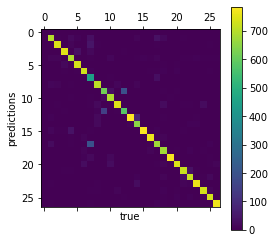

In [73]:
acc, true, pred = test_network(model1, test_loader)
print('Test accuracy: %0.3f' % acc)

display_contingency_matrix(len(model1.classes), pred, true)

#### Great example of overfitting:

In [74]:
model1c = modelCM(classes_collected)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model1c.parameters(), lr=.001)
train_network(model1c, train_loader_collected, val_loader_collected, criterion, optimizer, nepoch=100)

  0%|          | 0/100 [00:00<?, ?it/s]

EPOCH 0
 Train loss: 3.27793
   Val loss: 3.31252

EPOCH 1
 Train loss: 3.14403
   Val loss: 3.31833

EPOCH 2
 Train loss: 3.02879
   Val loss: 3.32129

EPOCH 3
 Train loss: 2.91485
   Val loss: 3.31418

EPOCH 4
 Train loss: 2.79778
   Val loss: 3.29239

EPOCH 5
 Train loss: 2.67427
   Val loss: 3.25436

EPOCH 6
 Train loss: 2.54261
   Val loss: 3.20103

EPOCH 7
 Train loss: 2.40273
   Val loss: 3.13590

EPOCH 8
 Train loss: 2.25669
   Val loss: 3.06405

EPOCH 9
 Train loss: 2.10792
   Val loss: 2.98829

EPOCH 10
 Train loss: 1.95985
   Val loss: 2.91042

EPOCH 11
 Train loss: 1.81565
   Val loss: 2.83149

EPOCH 12
 Train loss: 1.67802
   Val loss: 2.75352

EPOCH 13
 Train loss: 1.54908
   Val loss: 2.68004

EPOCH 14
 Train loss: 1.43006
   Val loss: 2.61367

EPOCH 15
 Train loss: 1.32129
   Val loss: 2.55644

EPOCH 16
 Train loss: 1.22228
   Val loss: 2.51001

EPOCH 17
 Train loss: 1.13241
   Val loss: 2.47501

EPOCH 18
 Train loss: 1.05085
   Val loss: 2.45045

EPOCH 19
 Train loss: 

Test accuracy: 2.778


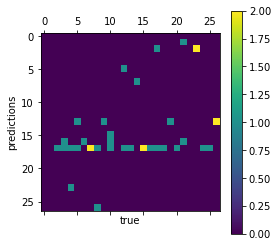

In [79]:
acc, true, pred = test_network(model1, test_loader_collected)
print('Test accuracy: %0.3f' % acc)

display_contingency_matrix(len(model1.classes), pred, true)

#### Test model on collected data

In [61]:
acc, true, pred = test_network(model1, data_loader_collected)
print('Test accuracy: %0.3f' % acc)

display_contingency_matrix(len(classes_collected), pred, true)

RuntimeError: expected scalar type Byte but found Float

### Smaller Kernel Size

In [17]:
class modelCMS(nn.Module):
    def __init__(self, classes):
        super().__init__()
        self.classes = classes
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3,3), stride=1),
            nn.MaxPool2d(kernel_size=(2,2), stride=2),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(1352, len(self.classes))
        )
            

    def forward(self, x):
        return self.layers(x)

In [18]:
model1s = modelCMS(classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model1s.parameters(), lr=.001)
train_network(model1s, train_loader, val_loader, criterion, optimizer, nepoch=10)

  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH 0
 Train loss: 1.23041
   Val loss: 0.97628

EPOCH 1
 Train loss: 0.87156
   Val loss: 0.82428

EPOCH 2
 Train loss: 0.71721
   Val loss: 0.68793

EPOCH 3
 Train loss: 0.61153
   Val loss: 0.61068

EPOCH 4
 Train loss: 0.54508
   Val loss: 0.57422

EPOCH 5
 Train loss: 0.50417
   Val loss: 0.53292

EPOCH 6
 Train loss: 0.47292
   Val loss: 0.50506

EPOCH 7
 Train loss: 0.44726
   Val loss: 0.50167

EPOCH 8
 Train loss: 0.42715
   Val loss: 0.48336

EPOCH 9
 Train loss: 0.40840
   Val loss: 0.46216



Test accuracy: 85.981


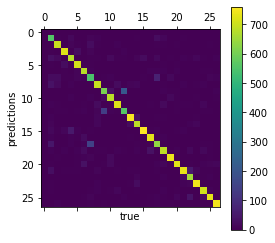

In [19]:
acc, true, pred = test_network(model1s, test_loader)
print('Test accuracy: %0.3f' % acc)

display_contingency_matrix(len(model1s.classes), pred, true)

### Double Convolution Layer with MaxPool

In [20]:
class modelCMCM(nn.Module):
    def __init__(self, classes):
        super().__init__()
        self.classes = classes
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(5,5), stride=1),
            nn.MaxPool2d(kernel_size=(2,2), stride=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=8, out_channels=64, kernel_size=(5,5), stride=1),
            nn.MaxPool2d(kernel_size=(2,2), stride=2),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(1024, len(self.classes))
        )
            

    def forward(self, x):
        return self.layers(x)

In [21]:
model2 = modelCMCM(classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model2.parameters(), lr=.001)
train_network(model2, train_loader, val_loader, criterion, optimizer, nepoch=10)

  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH 0
 Train loss: 0.76451
   Val loss: 0.41834

EPOCH 1
 Train loss: 0.35438
   Val loss: 0.30533

EPOCH 2
 Train loss: 0.28480
   Val loss: 0.28355

EPOCH 3
 Train loss: 0.24792
   Val loss: 0.26275

EPOCH 4
 Train loss: 0.22173
   Val loss: 0.25514

EPOCH 5
 Train loss: 0.20368
   Val loss: 0.25890

EPOCH 6
 Train loss: 0.18590
   Val loss: 0.24120

EPOCH 7
 Train loss: 0.17198
   Val loss: 0.24355

EPOCH 8
 Train loss: 0.15874
   Val loss: 0.24639

EPOCH 9
 Train loss: 0.14863
   Val loss: 0.23129



Test accuracy: 92.207


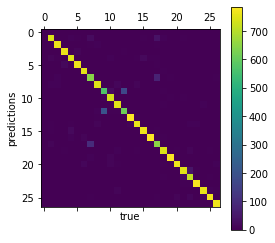

In [22]:
acc, true, pred = test_network(model2, test_loader)
print('Test accuracy: %0.3f' % acc)

display_contingency_matrix(len(model2.classes), pred, true)

### Single Convolution Network with Average Pool

In [23]:
class modelCA(nn.Module):
    def __init__(self, classes):
        super().__init__()
        self.classes = classes
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(5,5), stride=1),
            nn.AvgPool2d(kernel_size=(2,2), stride=2),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(1152, len(self.classes))
        )
            

    def forward(self, x):
        return self.layers(x)

In [24]:
model3 = modelCA(classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model3.parameters(), lr=.001)
train_network(model3, train_loader, val_loader, criterion, optimizer, nepoch=10)

  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH 0
 Train loss: 1.13020
   Val loss: 0.81349

EPOCH 1
 Train loss: 0.65135
   Val loss: 0.58294

EPOCH 2
 Train loss: 0.50856
   Val loss: 0.49838

EPOCH 3
 Train loss: 0.44802
   Val loss: 0.48435

EPOCH 4
 Train loss: 0.41661
   Val loss: 0.44393

EPOCH 5
 Train loss: 0.39233
   Val loss: 0.44952

EPOCH 6
 Train loss: 0.37350
   Val loss: 0.42694

EPOCH 7
 Train loss: 0.35506
   Val loss: 0.41322

EPOCH 8
 Train loss: 0.34208
   Val loss: 0.41412

EPOCH 9
 Train loss: 0.32794
   Val loss: 0.40368



Test accuracy: 87.284


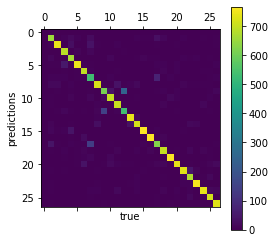

In [25]:
acc, true, pred = test_network(model3, test_loader)
print('Test accuracy: %0.3f' % acc)

display_contingency_matrix(len(model3.classes), pred, true)

## Visualizing Optimized Inputs

In [26]:
class OptimizeInput(nn.Module):
    def __init__(self, learned_model, input_shape=(1, 1, 28, 28)):
        super().__init__()
        self.learned_model = learned_model
        self.optimized_input = torch.zeros(input_shape, requires_grad=True)
        
    def forward(self):
        return self.learned_model(self.optimized_input)
    
    def parameters(self):
        return [self.optimized_input]

In [27]:
# Given model, get optimized input for each character
def get_optimized_inputs(model, nepochs = 10000):
    targets = torch.arange(len(model.classes)).long()
    optimized_inputs = {}

    for t in targets:
        # train input
        input_model = OptimizeInput(model)
        optimizer = torch.optim.Adam(input_model.parameters(), lr=.01)
        criterion = nn.CrossEntropyLoss()
        for epoch in range(nepochs):
            optimizer.zero_grad()
            outputs = input_model()
            loss = criterion(outputs, t.reshape(1))
            loss.backward()
            optimizer.step()
        print("finished %s with %0.5f loss" % (model.classes[t], loss.item()), end = "\t")
        optimized_inputs[model.classes[t]] = input_model.optimized_input.detach().numpy().reshape((28, 28))
        
        # test input
        tensor = torch.Tensor(optimized_inputs[model.classes[t]].reshape(1, 1, 28, 28))
        with torch.no_grad():
            output = model(tensor)
        prob = output.squeeze().detach().numpy()
        pred = model.classes[torch.argmax(output, dim=1)]
        print(f"Expected: {model.classes[t]}. Predicted: {pred}.")
    return optimized_inputs

In [28]:
optimized_inputs = get_optimized_inputs(model2, nepochs=1000)

finished N/A with 0.64832 loss	Expected: N/A. Predicted: N/A.
finished a with 0.00029 loss	Expected: a. Predicted: a.
finished b with 0.00020 loss	Expected: b. Predicted: b.
finished c with 0.00013 loss	Expected: c. Predicted: c.
finished d with 0.00031 loss	Expected: d. Predicted: d.
finished e with 0.00019 loss	Expected: e. Predicted: e.
finished f with 0.00012 loss	Expected: f. Predicted: f.
finished g with 0.00011 loss	Expected: g. Predicted: g.
finished h with 0.00022 loss	Expected: h. Predicted: h.
finished i with 0.00004 loss	Expected: i. Predicted: i.
finished j with 0.00006 loss	Expected: j. Predicted: j.
finished k with 0.00013 loss	Expected: k. Predicted: k.
finished l with 0.00003 loss	Expected: l. Predicted: l.
finished m with 0.00016 loss	Expected: m. Predicted: m.
finished n with 0.00016 loss	Expected: n. Predicted: n.
finished o with 0.00062 loss	Expected: o. Predicted: o.
finished p with 0.00009 loss	Expected: p. Predicted: p.
finished q with 0.00011 loss	Expected: q. 

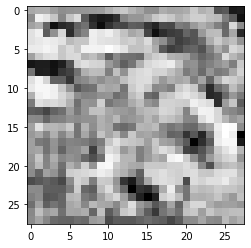

In [29]:
letter = 'b'
letter_visualized = optimized_inputs[letter].T
plt.imshow(letter_visualized, cmap='Greys_r')